# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

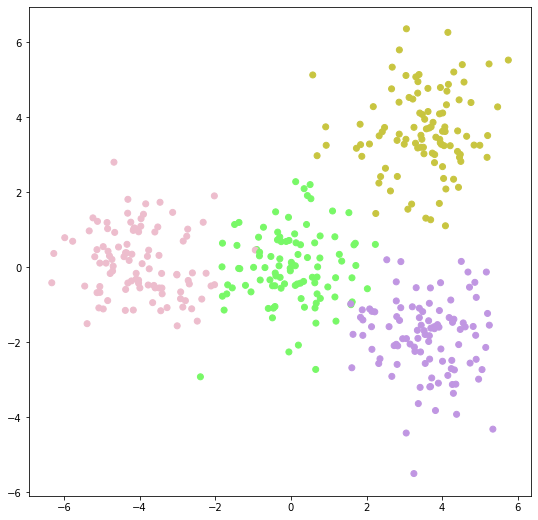

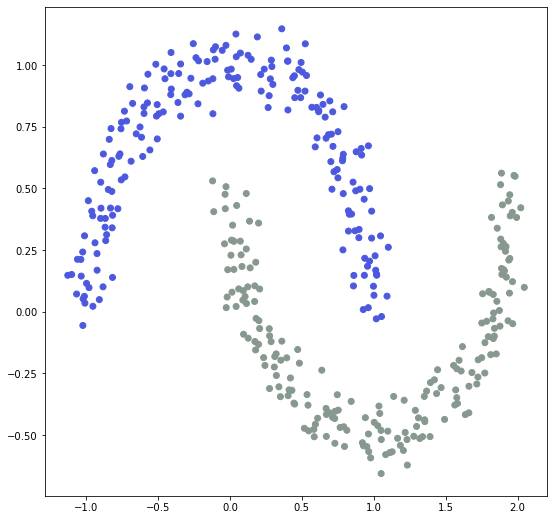

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.prev_centroids = None
        
    def _init_centroids(self, k, reinit=False):
        n = self.X.shape[0]
        
        if self.init == 'random':
            x_min = np.min(self.X, axis=0)
            x_max = np.max(self.X, axis=0)
            centroids = np.random.uniform(x_min, x_max, size=(k, self.X.shape[1]))
            
        elif self.init == 'sample':
            ind = np.random.choice(n, k)
            centroids = self.X[ind]
            
        elif self.init == 'k-means++':
            
            if reinit:
                m = self.distances[n, self.cur_clusters]
                m_sq = (m ** 2) / np.sum(m ** 2)
                centroids = np.random.choice(n, size=1, p = m_sq)
                
            else:
                first_centroid = np.random.choice(n, size=1)
                centroids = np.array(self.X[first_centroid])
                m = np.full(n, np.inf)

                for i in range(k - 1):
                    dist = np.linalg.norm(self.X - centroids[i], axis=1)

                    m = np.min((m, dist), axis=0)
                    m_sq = (m ** 2) / np.sum(m ** 2)

                    new_centroid = np.random.choice(n, size=1, p = m_sq)
                    centroids = np.vstack([centroids, self.X[new_centroid]])
                
        else:
            raise ValueError('Incorrect method for centroids initialization')
        
        return centroids
                
            
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.X = X.copy()
        n = self.X.shape[0]
        self.cur_clusters = np.zeros(n)
        self.distances = np.zeros(shape=(self.n_clusters, n))
        self.centroids = self._init_centroids(k=self.n_clusters)
        
        for i in range(self.max_iter):
            
            for cluster in range(self.n_clusters):
                centroid = self.centroids[cluster]
                
                #  recalc distances
                self.distances[cluster] = np.linalg.norm(self.X - centroid, axis=1)
            
            #  choose nearest centroid
            self.cur_clusters = np.argmin(self.distances, axis=0)
            
            used = np.unique(self.cur_clusters)
            diff = np.setdiff1d(np.arange(self.n_clusters), used)
            
            #  reinitialize centroids
            for i in diff:
                self.centroids[i] = self._init_centroids(k=1, reinit=True)
                    
            #  recalc centroids
            for cluster in range(self.n_clusters):
                xs = self.X[self.cur_clusters == cluster]
                if xs.shape[0]:
                    self.centroids[cluster] = np.array(np.mean(xs, axis=0))
            
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        
        pred_clusters = np.zeros(X.shape[0])
        
        for i, x in enumerate(X):
            nearest = np.argmin(np.linalg.norm(self.centroids - x, axis=1))
            pred_clusters[i] = nearest
            
        return pred_clusters.astype('int')

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

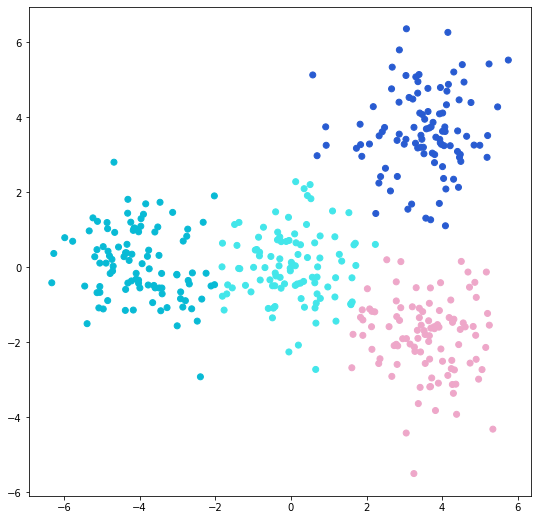

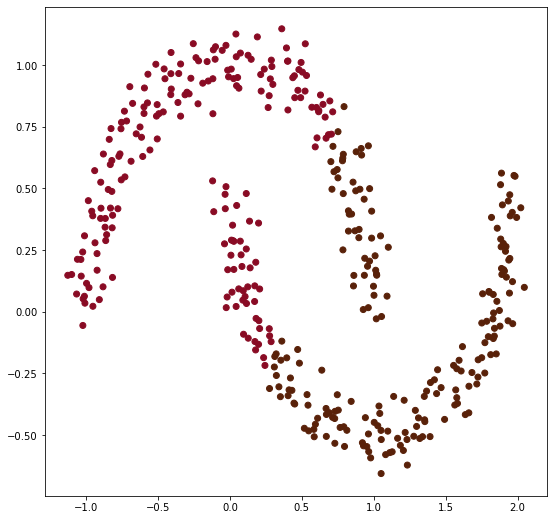

In [9]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.leaf_size = leaf_size
        self.min_samples = min_samples
        self.metric = metric
        
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        adjacency = tree.query_radius(X, r=self.eps)
        outliers = np.array([])
        n = X.shape[0]
        core_samples = np.full(n, False)
        
        clusters = np.full(n, np.inf)        
        color = 0
        
        for el in range(n):
            
            if clusters[el] != np.inf:
                continue
            
            if adjacency[el].shape[0] < self.min_samples:
                clusters[el] = -1
                continue
                
            queue = deque()
            queue.appendleft(el)
            clusters[el] = color
            
            while queue:
                point = queue.pop() 
                for neigh in adjacency[point]:
                    if clusters[neigh] == np.inf:
                        clusters[neigh] = color
                        if adjacency[neigh].shape[0] < self.min_samples:
                            continue
                        queue.appendleft(neigh)
            color += 1
            
        
        repl = np.max(clusters[clusters!=-1]) + 1
        clusters = np.where(clusters == -1, repl, clusters).astype('int')
        
        return clusters
        

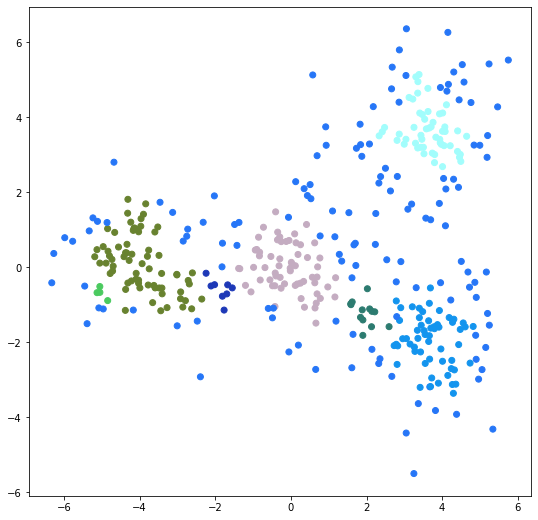

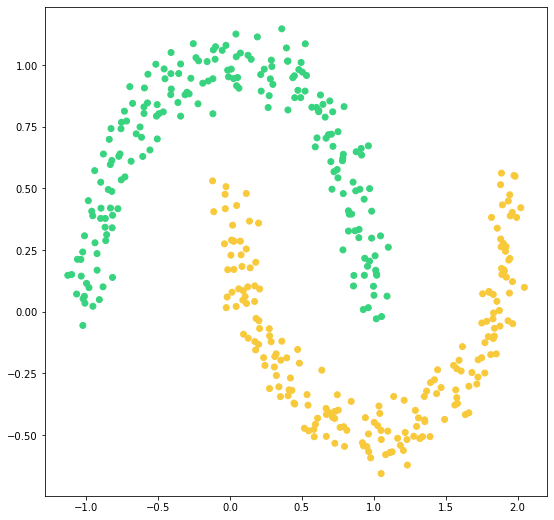

In [22]:
dbscan = DBScan(eps=0.6, min_samples=7, metric='manhattan')
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [23]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
    
    
    def _recalc_dist(self, clust1, clust2, n1=None, n2=None):
        if self.linkage == 'average':
            clust1 = clust1 * n1
            clust2 = clust2 * n2
            return np.where(clust1==np.inf, np.inf, np.where(clust2==np.inf, np.inf, (clust1 + clust2) / (n1 + n2)))
        
        elif self.linkage == 'single':
            return np.where(clust1==np.inf, np.inf, np.where(clust2==np.inf, np.inf, np.min((clust1, clust2), axis=0)))
        
        elif self.linkage == 'complete':
            return np.where(clust1==np.inf, np.inf, np.where(clust2==np.inf, np.inf, np.max((clust1, clust2), axis=0)))
        
        raise ValueError('Incorrect linkage')
    
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        n = X.shape[0]
        distances = np.zeros((n, n))
        
        for i, point in enumerate(X): 
            distances[:,i] = distances[i,:] = np.linalg.norm(X - point, axis=1)
            distances[i,i] = np.inf
        
        clusters = [[i] for i in range(n)]
        
        for _ in range(n - self.n_clusters):
            
            ind = np.unravel_index(distances.argmin(), distances.shape)
            min_i, min_j = ind[0], ind[1]
            
            cl1, cl2 = len(clusters[min_i]), len(clusters[min_j])
            clusters[min_i] = clusters[min_i] + clusters[min_j]
            clusters.pop(min_j)
            
            dist = self._recalc_dist(distances[min_i, :], distances[min_j, :], n1=cl1, n2=cl2)
            distances[min_i, :] = dist
            distances[:, min_i] = dist
            
            distances = np.delete(distances, min_j, axis=1)
            distances = np.delete(distances, min_j, axis=0)

        color = 0
        colors = np.zeros(n, dtype=int)
        for cl in clusters:
            for el in cl:
                colors[el] = color
            color += 1

        return colors


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

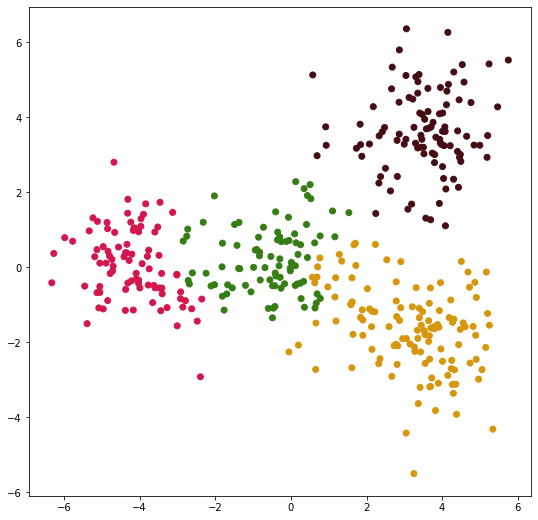

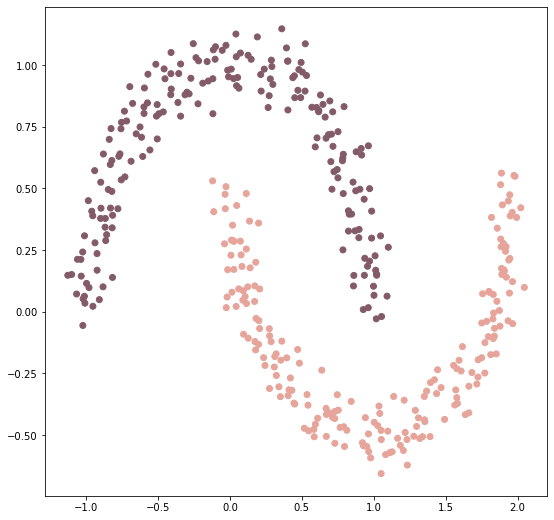

In [25]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage='complete')
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [27]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

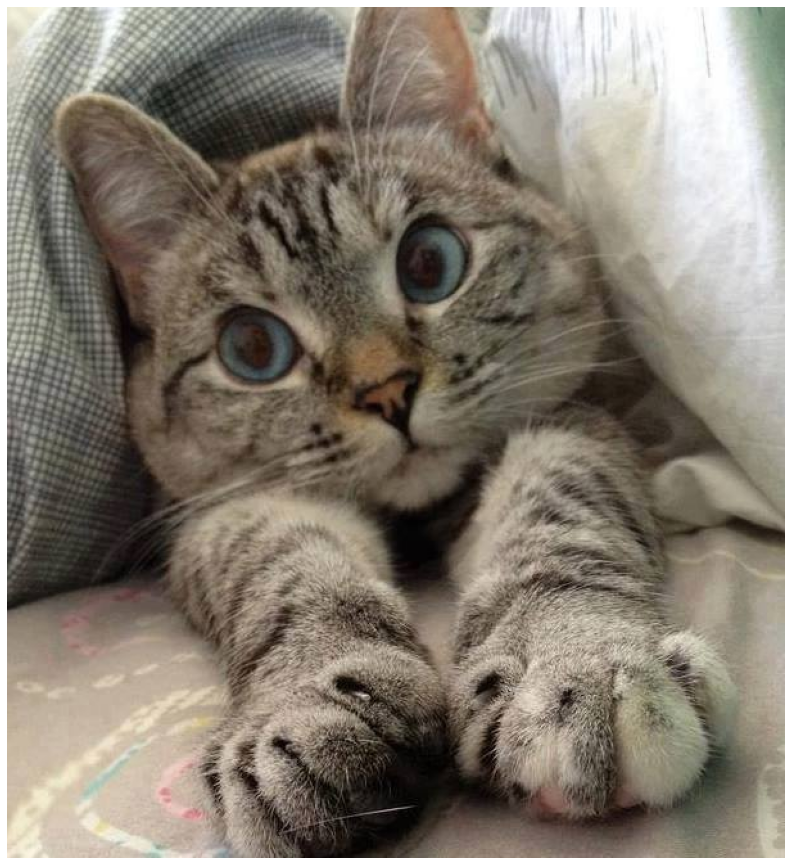

In [28]:
show_image(read_image("./image.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [29]:
def clusterize_image(image, **kwargs):
    init_shape = image.shape
    
    compressed = image[::4, ::4, :]
    image = image.reshape((-1, 3))
    data = compressed.reshape((-1, 3)).astype(np.float32)
    
    kmeans = KMeans(max_iter=20, init='k-means++', **kwargs)
    kmeans.fit(data)
    
    clusters = kmeans.predict(image.astype(np.float32))
    cluster_colors = kmeans.centroids.astype(int)
    
    recolored = np.array([cluster_colors[cluster] for cluster in clusters]) 
#     clusters_statistics(image, cluster_colors, clusters) # Very slow (:
    
    return recolored.reshape(init_shape)

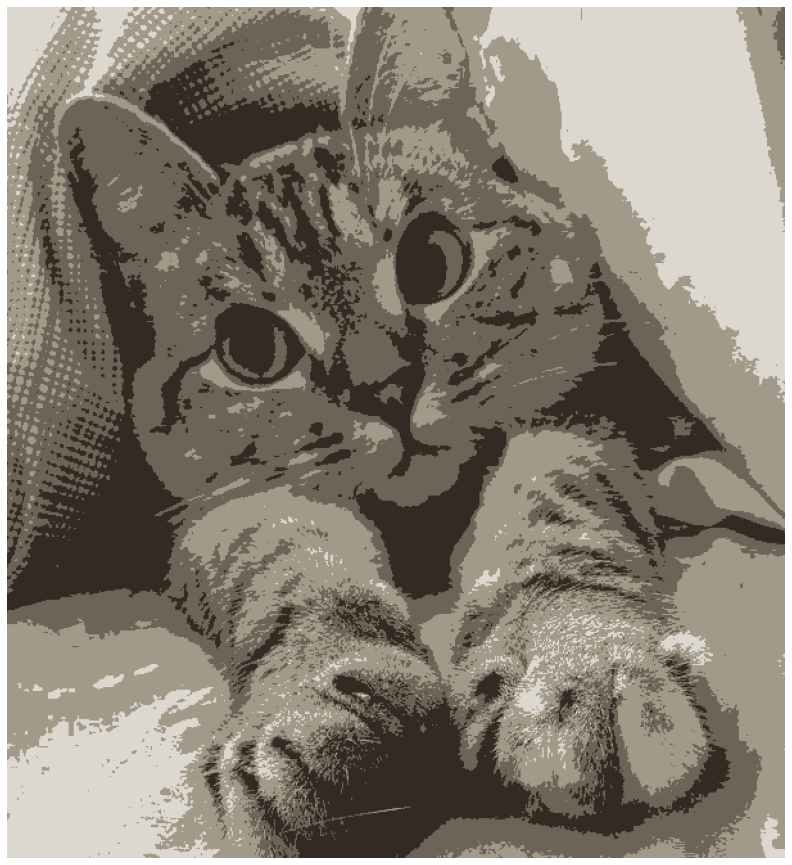

In [30]:
image = read_image("./image.jpg")
result = clusterize_image(image, n_clusters=4)
show_image(result)
save_image(result, "result.jpg")